# Pixel Flipping

Implementation of pixel-flipping algorithm (POC).

# LRP

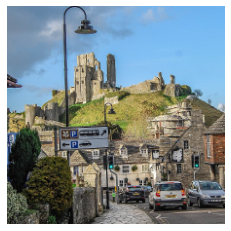

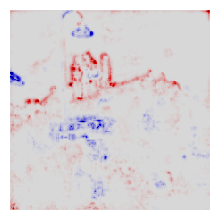

In [1]:
%load_ext autoreload
%autoreload 2

from typing import Callable
import torchvision
import numpy
import torch
from lrp import norm, image
from torchvision import transforms

from lrp.rules import LrpZBoxRule, LrpGammaRule, LrpEpsilonRule, LrpZeroRule

from typing import List, Dict, Union, Tuple
from lrp.filter import LayerFilter
from lrp.zennit.types import AvgPool, Linear
import lrp.rules as rules

from lrp.core import LRP

import lrp.plot
from matplotlib import pyplot as plt

# Normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# norm_fn: Callable[[torch.Tensor], torch.Tensor] = norm.ImageNetNorm()
norm_fn: Callable[[torch.Tensor], torch.Tensor] = transforms.Normalize(mean, std)

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224, 224)),
  transforms.ConvertImageDtype(torch.float),
  norm_fn
])

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

# Input data
# Image is in RGB mode with range [0,1]
img: numpy.array = image.load_normalized_img('../../data/castle.jpg')
X = transform(img)
# Simulate batch by adding a new dimension
X = torch.unsqueeze(X, 0)
# X=X[0]

plt.axis('off')
plt.imshow(inv_normalize(X[0]).numpy().transpose((1, 2, 0)))

# Model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = norm_fn(torch.zeros(*shape))
high: torch.Tensor = norm_fn(torch.ones(*shape))

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

from lrp.core import LRP

lrp = LRP(model)
lrp.convert_layers(name_map)
R: torch.Tensor = lrp.relevance(X)
lrp.heatmap(R, width=2, height=2)

# Pixel-flipping

The relevance scores have the same shape as the input and indicate how much each pixel contributed to the result.

In [2]:
print(X.shape)
print(R.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


Print value of neuron with highest activation in the last layer.

In [3]:
# 483 is the index of the neuron with the highest activation. In this case, 483 stands for castle class
lrp.model.forward(X)[0][483].item()

# Select the neuron with the highest activation automatically
# lrp.model.forward(X)[0].max().item()

11.028932571411133

Inspect minima and maxima of relevance scores:

In [4]:
# Remove empty first dimension, which was added in the first place to simulate batch:
r = R[0]

# Print minimum and maximum relevance scores
print(f'Maxima and minima in R: {torch.aminmax(R)}')

# Print maximum relevance score to compare with last line. It should be identical.
print(f'Maximum relevance score: {torch.amax(r).item()}')

Maxima and minima in R: torch.return_types.aminmax(
min=tensor(-0.0072),
max=tensor(0.0068))
Maximum relevance score: 0.006813136860728264


Extract indices with largest relevance scores.

1. Get indices of relevance score with largest value: `max_rel_indices_tensor`, `max_rel_indices_list`.
1. Get relevance score at these indices: `max_rel_val`.

In [5]:
max_rel_indices_tensor: torch.Tensor = (r==torch.max(r)).nonzero()

print(f'max_rel_indices_tensor {max_rel_indices_tensor}')
print(f'max_rel_indices_tensor.shape {max_rel_indices_tensor.shape}')

# max_rel_indices: tensor([[ 1, 83, 67]]) -> (1, 83, 67)
# Remove empty dimensions (flatten) and convert to list.
max_rel_indices_list: List = torch.flatten(max_rel_indices_tensor).tolist()

# Unwrap the list of indices into single variables:
# channel, height and width
# Dimensions of relevance scores r: 3 x 224 x 224
c, h, w = max_rel_indices_list

print('max_indices', max_rel_indices_list)

# Get relevance scores at indices of maximum relevance.
max_rel_val: float = r[c, h, w].item()

print(f'Value of maximum relevance: {max_rel_val}')

max_rel_indices_tensor tensor([[ 1, 83, 67]])
max_rel_indices_tensor.shape torch.Size([1, 3])
max_indices [1, 83, 67]
Value of maximum relevance: 0.006813136860728264


Print input value at the indices of the highest activation in the last layer. Indices were retrieved in a previous step—see `max_indices_list`.

In [6]:
c, h, w = max_rel_indices_list
X.detach()[0][c,w,h]

tensor(-0.3375)

## Test sampling from uniform distribution

The pixel-flipping algorithm requires the values to be replaced with a random value from a uniform distribution. Test this by sampling from a uniform distribution.

In [7]:
from numpy.random import default_rng

rng = default_rng(seed=42)
vals = rng.uniform(low=-1, high=1, size=5)
print(f'Sample values from uniform distribution: {vals}')

Sample values from uniform distribution: [ 0.5479121  -0.12224312  0.71719584  0.39473606 -0.8116453 ]


## Pixel-Flipping (PF) Algorithm

Initial score: 11.028932571411133
Step 0
Flipping X[0][1][83][67] to 0.5479120971119267
Score 0: 11.012924194335938
Step 1
Flipping X[0][1][79][90] to -0.12224312049589536
Score 1: 10.886446952819824
Step 2
Flipping X[0][1][58][95] to 0.7171958398227649
Score 2: 10.864102363586426
Step 3
Flipping X[0][1][102][31] to 0.3947360581187278
Score 3: 10.836287498474121
Step 4
Flipping X[0][1][65][71] to -0.8116453042247009
Score 4: 10.844576835632324
Step 5
Flipping X[0][1][65][71] to 0.9512447032735118
Score 5: 10.79824161529541
Step 6
Flipping X[0][2][1][222] to 0.5222794039807059
Score 6: 10.786388397216797
Step 7
Flipping X[0][1][83][68] to 0.5721286105539076
Score 7: 10.770289421081543
Step 8
Flipping X[0][1][57][94] to -0.7437727346489083
Score 8: 10.768549919128418
Step 9
Flipping X[0][1][57][94] to -0.09922812420886573
Score 9: 10.77051830291748
Step 10
Flipping X[0][1][102][21] to -0.25840395153483753
Score 10: 10.769089698791504
Step 11
Flipping X[0][1][101][30] to 0.853529977697203

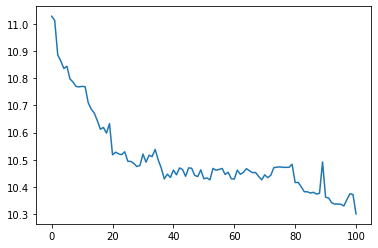

In [8]:
from numpy.random import default_rng

Y = X.clone().detach()
relevance_scores = R.clone().detach()

# Config
steps = 100
# Plotting config
should_plot = False
plot_every = 50

rng = default_rng(seed=42)
flip_vals = rng.uniform(low=-1, high=1, size=steps)

class_prediction_scores = []

# Add initial prediction score
score = lrp.model.forward(X)[0][483].item()
class_prediction_scores.append(score)
print(f'Initial score: {score}')

for i in range(steps):
    # FIXME: Relevance scores should not be updated.
    r = R[0]
    # FIXME: Is this needed?
    Y = Y.detach() 
    print(f'Step {i}')

    # # Mask syntax
    # flip_threshold = torch.max(r).item()
    # print(f'Flipping {Y[0][r==flip_threshold].count_nonzero()} elements greater than {flip_threshold} to {flip_vals[i]}')

    # Y[0][r==flip_threshold] = flip_vals[i]

    # 1. Sort by relevance
    # Get indices of max value in relevance scores
    r_max = (r==torch.max(r)).nonzero()
    
    for indices in r_max:
        # print(f'indices {indices}')
        j, k, l = indices.tolist()
        r_max_val = r[j, k, l].item()

        # Debugging
        # print('r_max indices:', r_max[0].tolist())
        # print(f'r_max val: {r_max_val}')

        # 2. Destroy pixel/patch
        print(f'Flipping X[0][{j}][{k}][{l}] to {flip_vals[i]}')
        
        # one-RGB-channel flip
        Y[0][j, k, l] = flip_vals[i]
        
        # three-RGB-channel flip
        # Y[0][0, k, l] = flip_vals[i]
        # Y[0][1, k, l] = flip_vals[i]
        # Y[0][2, k, l] = flip_vals[i]
    
    if should_plot and i % plot_every == 0:
        plt.imshow(inv_normalize(Y[0]).numpy().transpose((1, 2, 0)))

    # Evaluate f(Y)
    # Predict updated class score

    score = lrp.model.forward(Y)[0][483].item()
    print(f'Score {i}: {score}')

    # FIXME: Relevance scores should not be updated.
    R: torch.Tensor = lrp.relevance(Y)
    # Optionally, plot updated heatmap for debugging.
    if should_plot and i % plot_every == 0:
        lrp.heatmap(R, width=2, height=2)

    # 3. Measure decrease of f(Y)
    class_prediction_scores.append(score)

plt.plot(class_prediction_scores)
plt.show()

DEBUG     Initial classification score 11.028932571411133
DEBUG     Step 0
DEBUG     Flipping X[0][1, 83, 67] to 0.5479120971119267: 1 elements.
DEBUG     Classification score: 11.012924194335938
DEBUG     Step 1
DEBUG     Flipping X[0][1, 79, 90] to -0.12224312049589536: 1 elements.
DEBUG     Classification score: 10.886446952819824
DEBUG     Step 2
DEBUG     Flipping X[0][1, 58, 95] to 0.7171958398227649: 1 elements.
DEBUG     Classification score: 10.864102363586426
DEBUG     Step 3
DEBUG     Flipping X[0][1, 102, 31] to 0.3947360581187278: 1 elements.
DEBUG     Classification score: 10.836287498474121
DEBUG     Step 4
DEBUG     Flipping X[0][1, 65, 71] to -0.8116453042247009: 1 elements.
DEBUG     Classification score: 10.844576835632324
DEBUG     Step 5
DEBUG     Flipping X[0][1, 65, 71] to 0.9512447032735118: 1 elements.
DEBUG     Classification score: 10.79824161529541
DEBUG     Step 6
DEBUG     Flipping X[0][2, 1, 222] to 0.5222794039807059: 1 elements.
DEBUG     Classification

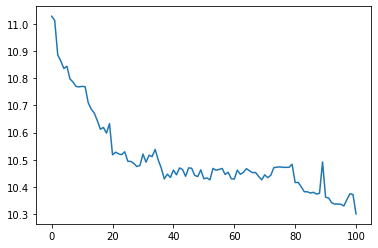

In [9]:
from pf.pixel_flipping import PixelFlipping

uniform_pf: PixelFlipping = PixelFlipping(perturbation_steps=steps, verbose=True)
input: torch.Tensor = X.clone().detach()
f: Callable[[torch.Tensor], float] = lambda X: lrp.model.forward(X)[0][483].item()
g: Callable[[torch.Tensor], torch.Tensor] = lambda X: lrp.relevance(X)

uniform_pf(input, relevance_scores.clone().detach(), f, g)
uniform_pf.plot()